In [24]:
%matplotlib inline
import random
import torch
import re
import collections
from d2l import torch as d2l

# 语言模型与数据集
假设长度为 $T$ 的文本序列中的词元依此为 $x_1, x_2, ... , x_T$, 于是, $x_t$ ($1 \le t \ge T$) 可以被认为是文本序列在时间步 $t$ 处的观测或者标签, 在给定这样的文本序列的时候, 语言模型的目标是估计序列的联合概率 $P(x_1, x_2, \ldots , x_T)$, 例如, 只需要抽取一个词元 $x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1)$, 一个理想的语言模型就可以基于模型本生生成自然文本(通俗来说就是只需要基于前面的对话片段中的文本就足以生成一个有意义的对话)

## 学习语言模型
此时不妨假设在单词级别对文本数据进行词元化, 通过基本的概率规则可以得到:
$$
P(x_1, x_2, \ldots, x_T) = \prod_{t=1}^{T} P(x_t \mid x_1, \ldots, x_{t-1})
$$
其实就是概率论中提到的链式法则, 例如包含四个单词的一个文本序列的概率为:
$$
P(deep, learning, is, fun) = P(deep)P(learning \mid deep)P(is \mid deep, learning)P(fun \mid is, deep, learning)
$$
所以为了训练语言模型, 需要计算单词的概率, 以及后面给定几个单词出现某一个单词的条件概率, 可以使用频率来间接估计概率, 比如估计 $deep$ 之后是 $learning$ 的概率:
$$
\hat{P}(learning \mid deep) = frac {n(deep, learning)}{n(deep)}
$$
但是连续单词对 $n(x, x')$ 可能出现的频率比较低, 所以估计这一类单词正确的概率比较困难, 并且许多合理的三个单词组合可能是存在的, 但是数据集中找不到, 除非提供某种解决方案，把这些单词组合成非零技术, 否则无法在语言模型和总使用这些它们

一种常见的策略是执行某种形式的拉普拉斯平滑, 具体方法是在所有计数中添加一个小常量, 使用 $n$ 表示训练集中单词数量, 使用 $m$ 表示唯一单词数量, 这一种解决方案可以有效处理单元素问题:
$$
\begin{align}
\hat{P}(x) &= \frac{n(x) + \epsilon_1/m}{n + \epsilon_1}, \\
\hat{P}(x' \mid x) &= \frac{n(x, x') + \epsilon_2 \hat{P}(x')}{n(x) + \epsilon_2}, \\
\hat{P}(x'' \mid x, x') &= \frac{n(x, x', x'') + \epsilon_3 \hat{P}(x'')}{n(x, x') + \epsilon_3}.
\end{align}
$$
并且其中 $\epsilon_1, \epsilon_2, \epsilon_3$ 都是超参数需要自己调节

但是这样的模型仅仅是指通过统计单词出现频率的方式来对于序列进行预测, 忽略了单词之间的连续, 容易变得无效

## 马尔可夫模型与n元语法
马尔可夫链强调前后状态的关联, 规定了概率传递关系, 如果 $P(x_{t+1} \mid x_t, \ldots , x_1) = P(x_{t+1} \mid x_t)$ 那么序列的分布满足一阶马尔可夫性质, 同时阶数越高对应的依赖关系越长, 通过这一种性质可以推导出许多可以用于序列建模的近似公式:
$$
\begin{align}
P(x_1, x_2, x_3, x_4) &= P(x_1) P(x_2) P(x_3) P(x_4), \\
P(x_1, x_2, x_3, x_4) &= P(x_1) P(x_2 \mid x_1) P(x_3 \mid x_2) P(x_4 \mid x_3), \\
P(x_1, x_2, x_3, x_4) &= P(x_1) P(x_2 \mid x_1) P(x_3 \mid x_1, x_2) P(x_4 \mid x_2, x_3).
\end{align}
$$
同时涉及到 $n$ 个变量的概率公式称为 $n$元语法模型

## 自然语言统计

In [25]:
#@save
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():  #@save
    """将时间机器数据集加载到文本行的列表中"""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [26]:
# 首先可以统计出现频率最高的 10 个单词
tokens = d2l.tokenize(read_time_machine())
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

可以发现出现频率最低的词看起来比较无聊, 这些词通常称为停用词, 因此可以被过滤掉, 但是我们依然会在模型中使用这些单词, 另外一个问题就是词平衰减的比较块, 最常用的单词对比, 第 10 个不如第 1 个的 $\frac{1}{5}$, 词频图如下

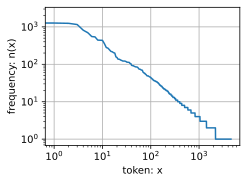

In [27]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
        xscale='log', yscale='log')

通过上图可以发现, 词频以一种明确的方式迅速衰减, 将前几个单词作为例外消除之后, 剩余的所有单词大致遵循双对数图上的一条直线， 表示单词频率满足齐普夫定律, 也就是第 $i$ 个最常用单词的频率 $n_i$ 为:
$$
n_i \propto \frac{1}{i^\alpha} 
\iff
\log n_i = -\alpha \log i + c,
$$
所以可以发现利用统计计数和平滑来建模但是是不可行的, 容易高估尾部单词的频率(随着 $i$ 增长, $log i$ 衰减速度减小, 所以导致尾部单词和中间单词加上常数之后进行估计的概率可能差不多), 下面统计 $n$ 元语法的频率出现的频率的概率分布

In [29]:
# 二元语法词频出现概率
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [30]:
# 三元语法词频出现概率
trigram_tokens = [triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

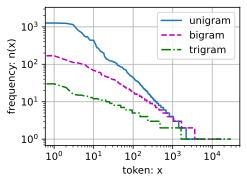

In [31]:
# 比较三种模型的词元频率
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

从这一种图可以看出:
1. 出了一元语法词, 单词序列分布也遵循齐普夫定律, 尽管支书 $\alpha$ 更小
2. 此表中 $n$ 元组数量并没有那么多, 说明语言中存在相当多的结果
3. 很多 $n$ 元组很少出现, 这使得拉普拉斯平滑不适合建模, 这里需要使用基于深度学习的模型

## 读取长序列
考虑的问题是: 如何使用神经网络来许训练语言模型, 模型中的网络一次处理具有预定义长度的一个小批量序列, 如何随机生成一个小批量数据的特征和标签以供读取

有与文本序列可以是任意长的, 于是任意长的序列可以被我们划分为具有相同时间步数的子序列, 当训练神经网络的时候, 这样的小批量子序列将被输入到模型中, 假设网络一次只需要处理 $n$ 个时间补的自叙列, 下图中表示从原始文本序列获得子序列的所有不同方式, 其中 $n=5$, 并且每一个时间步的词元对应与一个字符, 可以使用任意偏移量来指定初始位置:
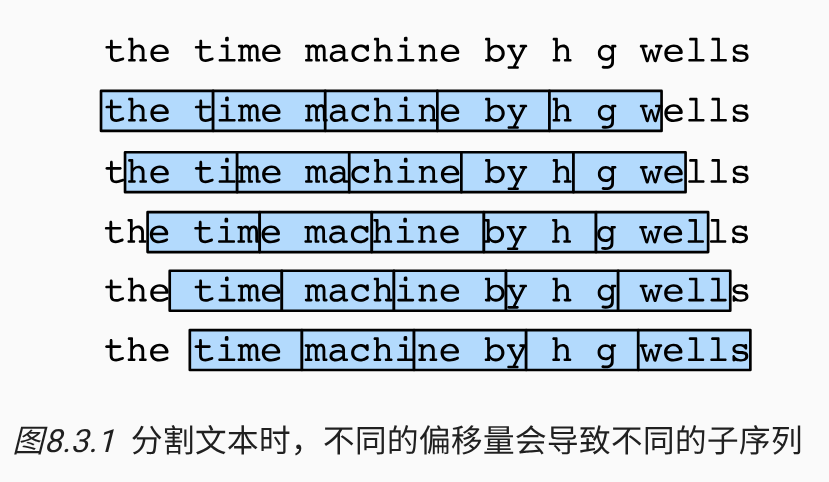
从上图中, 我们只需要选择一个偏移量, 那么用于训练网络的、所有可能的子序列的覆盖范围将是有限的, 因此, 我们可以从随机偏移量开始划分序列, 以同时获得覆盖性和随机性 ; 下面实现随机采样和顺序分区两种策略

### 随机采样

In [32]:
# 从数据中随机生成一个小批量
# batch_size: 指定了每一个小批量中子序列样本的数量
# num_steps:  每个子序列中预定义的时间步数
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [34]:
# 测试随机采样:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[28, 29, 30, 31, 32],
        [ 3,  4,  5,  6,  7]]) 
Y: tensor([[29, 30, 31, 32, 33],
        [ 4,  5,  6,  7,  8]])
X:  tensor([[23, 24, 25, 26, 27],
        [13, 14, 15, 16, 17]]) 
Y: tensor([[24, 25, 26, 27, 28],
        [14, 15, 16, 17, 18]])
X:  tensor([[ 8,  9, 10, 11, 12],
        [18, 19, 20, 21, 22]]) 
Y: tensor([[ 9, 10, 11, 12, 13],
        [19, 20, 21, 22, 23]])


### 顺序分区
在迭代过程中, 出了对于原始序列进行随机抽样之外, 还可以保证两个相邻的小批量中的子序列在原始序列中也是相邻的, 这一种策略基于小批量的迭代过程中保留了拆分的自叙列的顺序, 称为顺序分区

In [35]:
# 顺序分区
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [36]:
# 测试一下顺序采样的结果
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 3,  4,  5,  6,  7],
        [18, 19, 20, 21, 22]]) 
Y: tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]])
X:  tensor([[ 8,  9, 10, 11, 12],
        [23, 24, 25, 26, 27]]) 
Y: tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]])
X:  tensor([[13, 14, 15, 16, 17],
        [28, 29, 30, 31, 32]]) 
Y: tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]])


In [37]:
# 接下来可以把两种采样函数包装到以各类中, 作为数据迭代器
class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [39]:
# 定义一个 load_data_time_machine 用于返回数据器和词表
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

## 总结
- 语言模型是自然语言处理的关键。
- n元语法通过截断相关性，为处理长序列提供了一种实用的模型。
- 长序列存在一个问题：它们很少出现或者从不出现。
- 齐普夫定律支配着单词的分布，这个分布不仅适用于一元语法，还适用于其他
元语法。
- 通过拉普拉斯平滑法可以有效地处理结构丰富而频率不足的低频词词组。
- 读取长序列的主要方式是随机采样和顺序分区。在迭代过程中，后者可以保证来自两个相邻的小批量中的子序列在原始序列上也是相邻的。